In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Import thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error


# 2. Đọc file csv và gắng index với giá Close

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Analyst/Datasets/AMD Historical Data.csv')
df1=df.reset_index()['Price']
len(df)

1624

# 3.Scaler data

In [4]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

# 4. Chia train test

In [5]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
print(train_size, test_size, val_size)

974 487 163


# 5.Hàm Create Dataset

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
# import numpy
# # convert an array of values into a dataset matrix
# def create_dataset(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-time_step-1):
# 		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
# 		dataX.append(a)
# 		dataY.append(dataset[i + time_step, 0])
# 	return numpy.array(dataX), numpy.array(dataY)

#6.Reshape into X=t,t+1,t+2..t+99 and Y=t+100

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X, y = create_dataset(df1, time_step)

X_train = X[:train_size-100]
X_test = X[train_size-100:train_size-100+test_size]
X_val = X[train_size-100+test_size:]

y_train = y[:train_size-100]
ytest = y[train_size-100:train_size-100+test_size]
yval = y[train_size+test_size-100:]

In [10]:
# time_step = 100
# X_train, y_train = create_dataset(train_data, time_step)
# X_val, yval = create_dataset(val_data, time_step)
# X_test, ytest = create_dataset(test_data, time_step)

# 7. Reshape input to be [samples, time steps, features] which is required for LSTM

In [11]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

# 8. Define GRU Model

In [12]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 9. Fit mô hình với dữ liệu train

In [13]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 5s 138ms/step - loss: 0.0260 - val_loss: 0.0683
Epoch 2/100
14/14 [==============================] - 1s 88ms/step - loss: 0.0082 - val_loss: 0.0391
Epoch 3/100
14/14 [==============================] - 1s 81ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 4/100
14/14 [==============================] - 1s 77ms/step - loss: 4.0582e-04 - val_loss: 0.0020
Epoch 5/100
14/14 [==============================] - 1s 89ms/step - loss: 2.4457e-04 - val_loss: 0.0012
Epoch 6/100
14/14 [==============================] - 2s 110ms/step - loss: 2.0526e-04 - val_loss: 0.0013
Epoch 7/100
14/14 [==============================] - 2s 109ms/step - loss: 1.9366e-04 - val_loss: 0.0013
Epoch 8/100
14/14 [==============================] - 2s 125ms/step - loss: 1.8763e-04 - val_loss: 0.0012
Epoch 9/100
14/14 [==============================] - 1s 108ms/step - loss: 1.8635e-04 - val_loss: 0.0015
Epoch 10/100
14/14 [==============================] - 1s 52ms/step - lo

# 10.Dự báo dữ liệu test, val

In [14]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val


In [15]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE, MAE

In [16]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

Validation RMSE: 84.59345808704195
Validation MAE: 82.9012707783331
Testing RMSE: 99.72767581141794
Testing MAE: 97.60833614986423


# 13. Dự báo 30 ngày tiếp theo

In [17]:
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps = 102
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.39729623 0.43969025 0.4276808  0.42905893 0.43069957 0.43227458
 0.41291508 0.43063394 0.49291246 0.51699698 0.50242814 0.48661242
 0.50124688 0.49324058 0.48352802 0.47217483 0.48300302 0.50150938
 0.49645623 0.46298727 0.45261845 0.44126526 0.44021525 0.46082163
 0.44992781 0.45439034 0.45314346 0.45124032 0.46534978 0.47243733
 0.47007481 0.47630923 0.49770311 0.48890931 0.47998425 0.47565297
 0.5113532  0.52598766 0.57140045 0.579538   0.57277858 0.56700354
 0.57783174 0.5955506  0.58025988 0.57146607 0.55801286 0.56805355
 0.5798005  0.58065363 0.57113794 0.56660979 0.54488778 0.54429715
 0.5640504  0.55453472 0.5433784  0.54180339 0.53957212 0.52723455
 0.52664392 0.52769392 0.52880956 0.51778449 0.5121407  0.48739992
 0.50144376 0.51128757 0.52395327 0.52605329 0.52749705 0.47309358
 0.50584066 0.52703767 0.56116288 0.56129413 0.57415671 0.57468172
 0.56260664 0.57665048 0.60342565 0.61832261 0.64575404 0.63190707
 0.64621341 0.64700092 0.6479853  0.7272608  0.771

In [18]:
x_input.shape

(1, 102, 1)

# 14.Vẽ hình

Validation RMSE: 84.59345808704195
Validation MAE: 82.9012707783331
Testing RMSE: 99.72767581141794
Testing MAE: 97.60833614986423


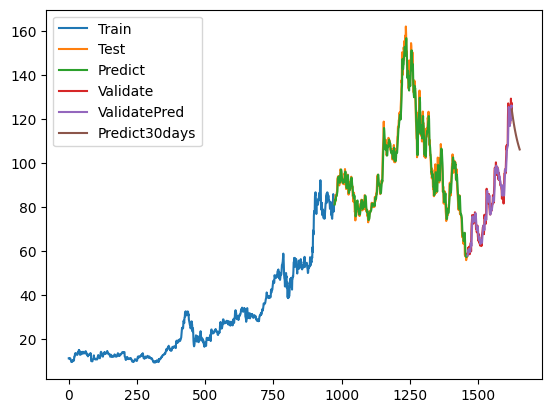

In [24]:
# 14.Vẽ hình
print('Validation RMSE:', valid_rmse)
print('Validation MAE:', valid_mae)

print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()
# print(lst_output)

In [20]:
# train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
# plt.plot(scaler.inverse_transform(train_data))
# test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,scaler.inverse_transform(test_data))
# test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
# plt.plot(test_data_index,(y_pred))
# val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,scaler.inverse_transform(val_data))
# val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
# plt.plot(val_data_index,y_pred_val)
# prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
# plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
# plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
# plt.show()

# 15.Vẽ hình Predict 30 days


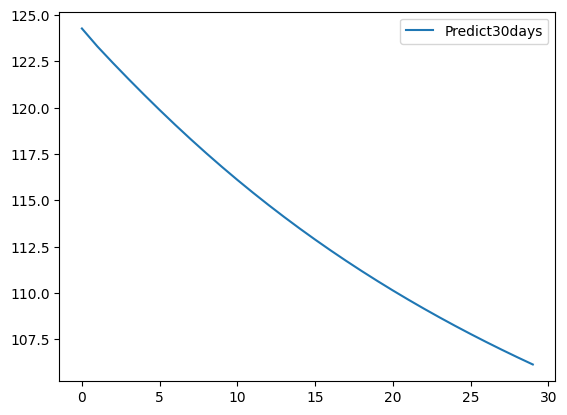

In [21]:
prediect_data_index = pd.RangeIndex(start=0, stop=30, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Predict30days'])
plt.show()

In [23]:
scaler.inverse_transform(lst_output)[:30, 0]


array([124.28027208, 123.30705807, 122.41541449, 121.54995591,
       120.70468786, 119.88074565, 119.0791556 , 118.30064434,
       117.54542074, 116.81340308, 116.10422804, 115.41743242,
       114.75241677, 114.10854531, 113.48514593, 112.88156468,
       112.29702956, 111.73087753, 111.18240015, 110.65097073,
       110.13591716, 109.63656732, 109.15233086, 108.68262649,
       108.22690017, 107.78456154, 107.3551383 , 106.93813092,
       106.53303985, 106.13945638])